In [2]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler


In [3]:
# data prepartion
import os
from google.colab import drive
drive.mount('/content/drive')

file_path = 'exchangedata.csv' # location to file



Mounted at /content/drive


In [4]:
data = pd.read_csv(file_path)
data.head()

,domain,trust_score,blacklisted,ip_bad_count_bad,ssl_valid,ip_country,anonymous_whois,dnsblock_threat_count,whois_registration_duration,whois_valid_email,avg_review_score,facebook_comments_negative_count,facebook_comments_positive_count,scamadviser_votes_legit,scamadviser_votes_scam,scamadviser_votes_fake,is_legit
0,merlinswap.org,56.0,0,0.29,1,US,1,0,0.49,0,0.00,0.0,0.0,0,0,0,1
1,fast.exchange.onetrading.com,80.0,0,0.00,1,US,1,0,20.01,1,0.00,0.0,0.0,0,0,0,1
2,dackieswap.xyz,1.0,0,0.41,1,US,1,0,1.24,0,1.00,0.0,0.0,0,0,0,1
3,coinw.com,100.0,0,0.29,1,US,1,0,15.30,0,2.25,0.0,0.0,0,1,0,1
4,phemex.com,1.0,0,0.10,1,NL,1,0,8.37,0,1.79,0.0,0.0,0,6,0,1


In [5]:
print(data.info())
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419 entries, 0 to 418
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   domain                            418 non-null    object 
 1   trust_score                       419 non-null    float64
 2   blacklisted                       419 non-null    int64  
 3   ip_bad_count_bad                  419 non-null    float64
 4   ssl_valid                         419 non-null    int64  
 5   ip_country                        419 non-null    object 
 6   anonymous_whois                   419 non-null    int64  
 7   dnsblock_threat_count             419 non-null    int64  
 8   whois_registration_duration       419 non-null    float64
 9   whois_valid_email                 419 non-null    int64  
 10  avg_review_score                  419 non-null    float64
 11  facebook_comments_negative_count  419 non-null    float64
 12  facebook

In [6]:

# drop domain name - not needed
data.drop('domain', axis=1, inplace=True)


# Convert boolean columns to int
data['anonymous_whois'] = data['anonymous_whois'].astype(int)
data['ssl_valid'] = data['ssl_valid'].astype(int)
data['whois_valid_email'] = data['whois_valid_email'].astype(int)
data['blacklisted'] = data['blacklisted'].astype(int)
data['is_legit'] = data['is_legit'].astype(int)

In [7]:
#  encoding categorical features

# count the number of unique countries in the ip_country column
unique_countries = data['ip_country'].nunique()
print(f"Number of unique countries: {unique_countries}")

#
one_hot = pd.get_dummies(data['ip_country'])

# Concatenate the one-hot encoded columns back to the original DataFrame
data = pd.concat([data, one_hot], axis=1)

# drop ip country
data = data.drop('ip_country', axis=1)

data.head(10)

Number of unique countries: 22


,trust_score,blacklisted,ip_bad_count_bad,ssl_valid,anonymous_whois,dnsblock_threat_count,whois_registration_duration,whois_valid_email,avg_review_score,facebook_comments_negative_count,...,IN,JP,LT,MY,NL,PT,RU,SG,SK,US
0,56.0,0,0.29,1,1,0,0.49,0,0.00,0.0,...,False,False,False,False,False,False,False,False,False,True
1,80.0,0,0.00,1,1,0,20.01,1,0.00,0.0,...,False,False,False,False,False,False,False,False,False,True
2,1.0,0,0.41,1,1,0,1.24,0,1.00,0.0,...,False,False,False,False,False,False,False,False,False,True
3,100.0,0,0.29,1,1,0,15.30,0,2.25,0.0,...,False,False,False,False,False,False,False,False,False,True
4,1.0,0,0.10,1,1,0,8.37,0,1.79,0.0,...,False,False,False,False,True,False,False,False,False,False
5,82.0,0,0.15,1,1,0,1.67,1,0.00,0.0,...,False,False,False,False,True,False,False,False,False,False
6,62.0,0,0.00,1,1,0,23.50,0,2.41,0.0,...,False,False,False,False,False,False,False,False,False,True
7,100.0,0,0.00,1,1,0,22.99,0,1.98,0.0,...,False,False,False,False,False,False,False,False,False,True
8,1.0,0,0.11,1,1,0,9.05,1,1.42,0.0,...,False,False,False,False,True,False,False,False,False,False
9,65.0,0,0.00,1,0,0,6.59,1,1.67,0.0,...,False,False,False,False,False,False,False,False,False,True


In [8]:
# Scaling numerical features
scaler = StandardScaler()
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

In [9]:

# Define the model
model_lgb = lgb.LGBMClassifier(random_state=42)


# Set up k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(model_lgb, X_train, y_train, cv=kf, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

[LightGBM] [Info] Number of positive: 102, number of negative: 166
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 221
[LightGBM] [Info] Number of data points in the train set: 268, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.380597 -> initscore=-0.487015
[LightGBM] [Info] Start training from score -0.487015
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [10]:

# 6. Model Training with Parameter Tuning
params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'num_leaves': [31, 50, 70]
}

# model = lgb.LGBMClassifier(random_state=42)
grid_search = GridSearchCV(model_lgb, params, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Train the model
model_lgb.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 135, number of negative: 200
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 284
[LightGBM] [Info] Number of data points in the train set: 335, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.402985 -> initscore=-0.393043
[LightGBM] [Info] Start training from score -0.393043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

LGBMClassifier(random_state=42)

In [11]:
# best model estimator include into paper
best_model = grid_search.best_estimator_
best_model

LGBMClassifier(learning_rate=0.01, max_depth=5, n_estimators=300,
               random_state=42)

In [12]:
# Make predictions on the test set
predictions = best_model.predict(X_test)
prob_predictions = best_model.predict_proba(X_test)[:, 1]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


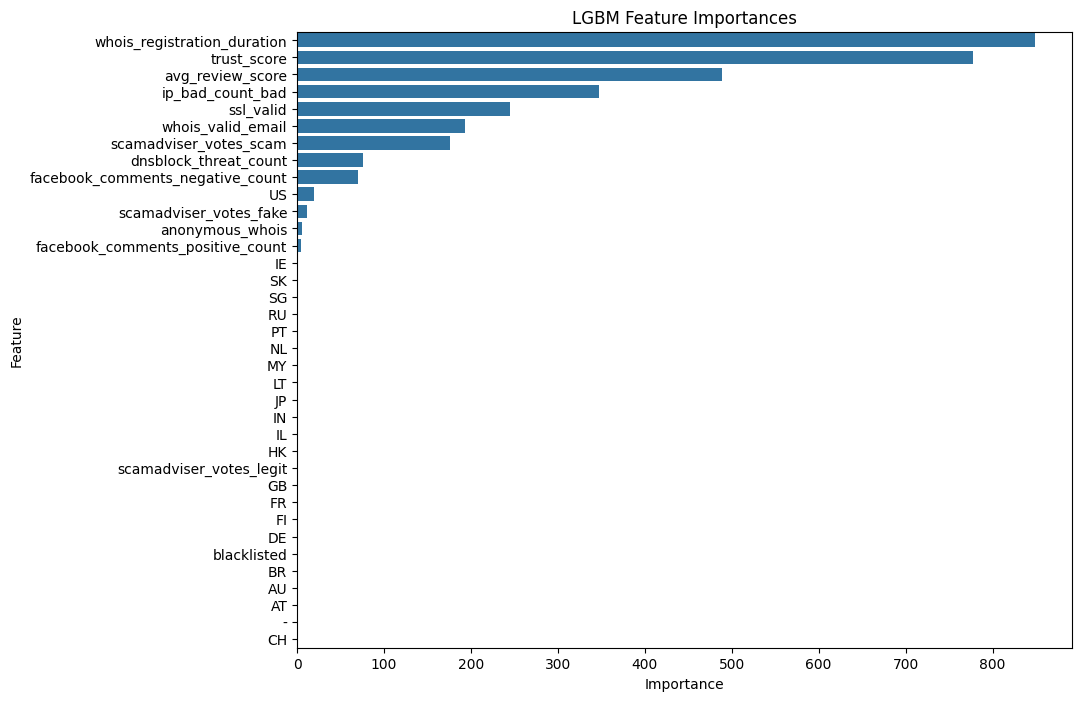

In [23]:
# Feature Importance
importances = best_model.feature_importances_
features = X.columns

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('LGBM Feature Importances')
plt.show()

In [26]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# Evaluate the model

accuracy = round(accuracy_score(y_test, predictions),2)
precision = round(precision_score(y_test, predictions),2)
recall = round(recall_score(y_test, predictions),2)
f1 = round(f1_score(y_test, predictions),2)

# Create an empty dataframe
metrics_df = pd.DataFrame(columns=['Model Name', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Add metrics for a model
metrics_df.loc[0] = ['LGBM', accuracy, precision, recall, f1]

print(metrics_df)

metrics_df.to_csv('lgbm.csv', index=False)

  Model Name  Accuracy  Precision  Recall  F1-Score
0       LGBM      0.95       0.97    0.92      0.94


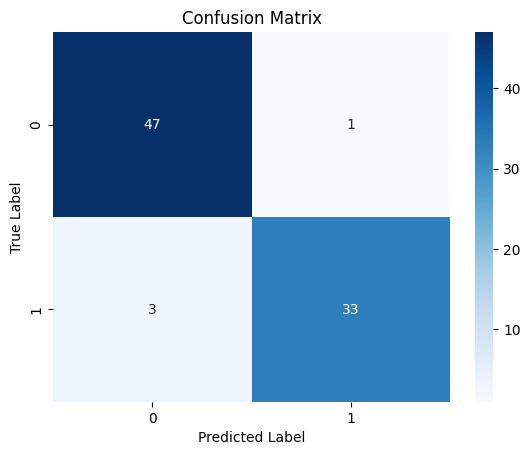

In [21]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()